2025-05-25T07:38:51+0300.428 INFO     db                        160 : 📁 backend Initializing MongoDBClient local_connection


2025-05-25T07:38:51+0300.445 INFO     db                        543 : 📁 backend Attempting to connect to MongoDB for the first time or after failure.


Current working directory: /Users
MongoDB connection string: local_connection
MongoDB database name: v4vapp-dev
MongoDB database user: v4vapp-dev-user
MongoDB collection name: hive_rates
First date: 2025-04-20 19:39:49.985000+00:00
Last date: 2025-05-25 04:32:06.298000+00:00
Num of documents: 25176


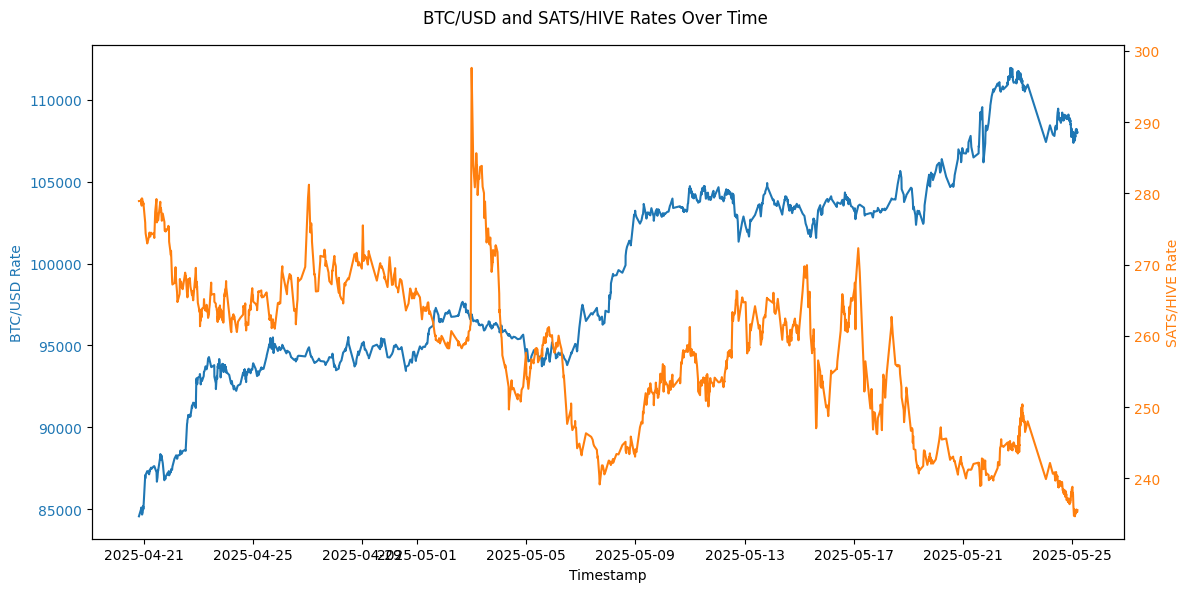

In [43]:
from v4vapp_backend_v2.database.db import MongoDBClient
from v4vapp_backend_v2.config.setup import InternalConfig
import os
import pandas as pd
import matplotlib.pyplot as plt

# Change working directory to /src
os.chdir(os.path.abspath(os.path.join(os.getcwd(), "..")))
print("Current working directory:", os.getcwd())

CONFIG = InternalConfig(config_filename="devhive.config.yaml").config

async with MongoDBClient(
    db_conn=CONFIG.dbs_config.default_connection,
    db_name=CONFIG.dbs_config.default_name,
    db_user=CONFIG.dbs_config.default_user,
) as client:
    collection = await client.get_collection("hive_rates")

    print("MongoDB connection string:", client.db_conn)
    print("MongoDB database name:", client.db_name)
    print("MongoDB database user:", client.db_user)
    print("MongoDB collection name:", collection.name)

    first_doc = await collection.find_one(sort=[("timestamp", 1)])
    last_doc = await collection.find_one(sort=[("timestamp", -1)])
    print("First date:", first_doc["timestamp"] if first_doc else None)
    print("Last date:", last_doc["timestamp"] if last_doc else None)
    print("Num of documents:", await collection.count_documents({}))

    # Query all btc_usd rates
    btc_usd_cursor = collection.find({"pair": "btc_usd"}, sort=[("timestamp", 1)])
    btc_usd_docs = await btc_usd_cursor.to_list(length=None)

    # Query all sats_hive rates
    sats_hive_cursor = collection.find({"pair": "sats_hive"}, sort=[("timestamp", 1)])
    sats_hive_docs = await sats_hive_cursor.to_list(length=None)

    if btc_usd_docs and sats_hive_docs:
        df_btc_usd = pd.DataFrame(btc_usd_docs)
        df_sats_hive = pd.DataFrame(sats_hive_docs)

        fig, ax1 = plt.subplots(figsize=(12, 6))

        ax1.plot(
            df_btc_usd["timestamp"], df_btc_usd["value"], label="BTC/USD Rate", color="tab:blue"
        )
        ax1.set_xlabel("Timestamp")
        ax1.set_ylabel("BTC/USD Rate", color="tab:blue")
        ax1.tick_params(axis="y", labelcolor="tab:blue")

        ax2 = ax1.twinx()
        ax2.plot(
            df_sats_hive["timestamp"],
            df_sats_hive["value"],
            label="SATS/HIVE Rate",
            color="tab:orange",
        )
        ax2.set_ylabel("SATS/HIVE Rate", color="tab:orange")
        ax2.tick_params(axis="y", labelcolor="tab:orange")

        fig.suptitle("BTC/USD and SATS/HIVE Rates Over Time")
        fig.tight_layout()
        plt.show()
    else:
        print("No data found for btc_usd or sats_hive.")


Total records after filtering 0 delta: 123


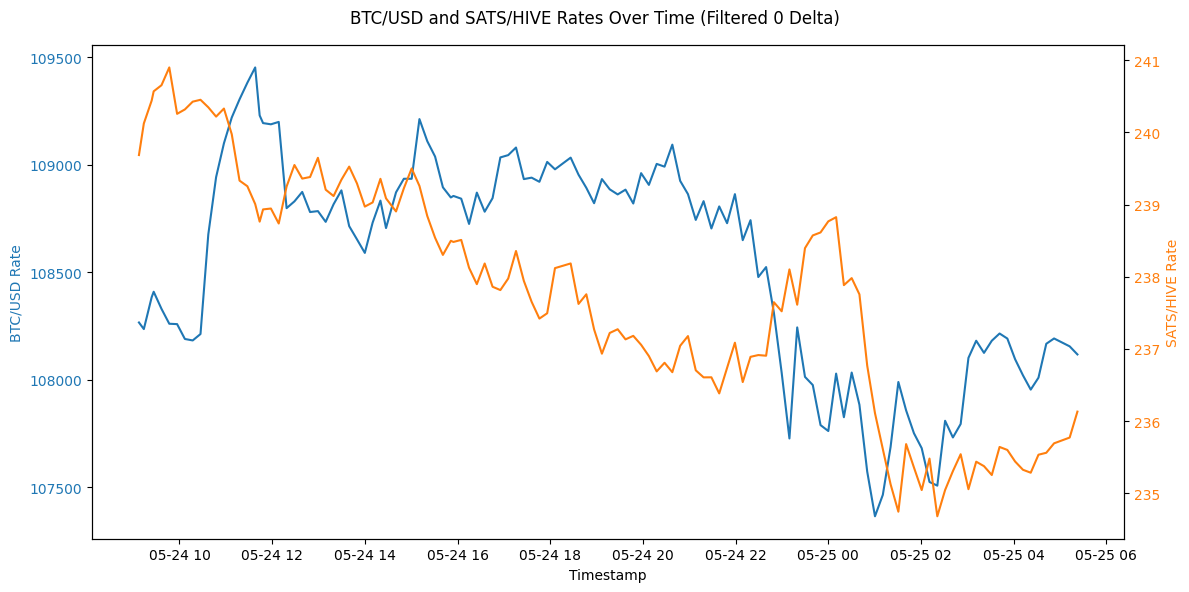

In [47]:
import numpy as np

# Query all documents from the combined collection
combined_cursor = collection.find({}, sort=[("timestamp", 1)])
combined_docs = await combined_cursor.to_list(length=None)

if combined_docs:
    df = pd.DataFrame(combined_docs)
    # Ensure timestamp is datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(df["timestamp"]):
        df["timestamp"] = pd.to_datetime(df["timestamp"])

    # Calculate time deltas between consecutive records
    df = df.sort_values("timestamp")
    df["delta"] = df["timestamp"].diff().dt.total_seconds().fillna(0)

    # Filter out rows where delta == 0 (ignore 0 gap records)
    df = df[df["delta"] != 0]

    print(f"Total records after filtering 0 delta: {len(df)}")

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot BTC/USD on left y-axis
    ax1.plot(df["timestamp"], df["btc_usd"], label="BTC/USD Rate", color="tab:blue")
    ax1.set_xlabel("Timestamp")
    ax1.set_ylabel("BTC/USD Rate", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # Plot SATS/HIVE on right y-axis
    ax2 = ax1.twinx()
    ax2.plot(df["timestamp"], df["sats_hive"], label="SATS/HIVE Rate", color="tab:orange")
    ax2.set_ylabel("SATS/HIVE Rate", color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")

    fig.suptitle("BTC/USD and SATS/HIVE Rates Over Time (Filtered 0 Delta)")
    fig.tight_layout()
    plt.show()
else:
    print("No data found in hive_rates_combined collection.")


In [8]:
from datetime import datetime, timezone, timedelta

# Target datetime in UTC (assuming input is UTC)
target_dt = datetime(2025, 5, 3, 12, 45, tzinfo=timezone.utc)


# Find closest hive_usd rate
df_hive_usd = pd.DataFrame(
    [doc for doc in btc_usd_docs + sats_hive_docs if doc["pair"] == "hive_usd"]
)
if not df_hive_usd.empty:
    df_hive_usd["timedelta"] = (df_hive_usd["timestamp"] - target_dt).abs()
    closest_hive_usd_row = df_hive_usd.loc[df_hive_usd["timedelta"].idxmin()]
    print("Closest HIVE/USD rate:")
    print(closest_hive_usd_row[["timestamp", "value", "timedelta"]])
else:
    print("No data found for hive_usd.")

# Find closest hive_hbd rate
df_hive_hbd = pd.DataFrame(
    [doc for doc in btc_usd_docs + sats_hive_docs if doc["pair"] == "hive_hbd"]
)
if not df_hive_hbd.empty:
    df_hive_hbd["timedelta"] = (df_hive_hbd["timestamp"] - target_dt).abs()
    closest_hive_hbd_row = df_hive_hbd.loc[df_hive_hbd["timedelta"].idxmin()]
    print("Closest HIVE/HBD rate:")
    print(closest_hive_hbd_row[["timestamp", "value", "timedelta"]])
else:
    print("No data found for hive_hbd.")


# Find closest BTC/USD rate
df_btc_usd["timedelta"] = (df_btc_usd["timestamp"] - target_dt).abs()
closest_btc_usd_row = df_btc_usd.loc[df_btc_usd["timedelta"].idxmin()]
print("Closest BTC/USD rate:")
print(closest_btc_usd_row[["timestamp", "value"]])

# Find closest SATS/HIVE rate
df_sats_hive["timedelta"] = (df_sats_hive["timestamp"] - target_dt).abs()
closest_sats_hive_row = df_sats_hive.loc[df_sats_hive["timedelta"].idxmin()]
print("Closest SATS/HIVE rate:")
print(closest_sats_hive_row[["timestamp", "value"]])

# Optionally, drop the helper column if you don't need it
df_btc_usd.drop(columns=["timedelta"], inplace=True)
df_sats_hive.drop(columns=["timedelta"], inplace=True)

No data found for hive_usd.
No data found for hive_hbd.
Closest BTC/USD rate:
timestamp    2025-05-03 13:12:52.251000+00:00
value                                96190.01
Name: 1062, dtype: object
Closest SATS/HIVE rate:
timestamp    2025-05-03 13:12:52.251000+00:00
value                                273.1053
Name: 1062, dtype: object


In [ ]:
from pymongo import AsyncMongoClient
import asyncio

old_client = MongoDBClient(
    db_conn=CONFIG.dbs_config.default_connection,
    db_name=CONFIG.dbs_config.default_name,
    db_user=CONFIG.dbs_config.default_user,
)

new_client = AsyncMongoClient(old_client.uri, tz_aware=True)
db = new_client[CONFIG.dbs_config.default_name]
collection = db["hive_rates"]
doc = await collection.find_one({"pair": "btc_usd"})


async def find_nearest_pair_rate(collection, pair, target_dt):
    """
    Find the document for the given pair with the timestamp nearest to target_dt.

    Args:
        collection: AsyncCollection instance.
        pair (str): The pair to search for (e.g., 'btc_usd').
        target_dt (datetime): The target datetime (must be timezone-aware).

    Returns:
        dict or None: The nearest document, or None if not found.
    """
    # Find the document just before or at target_dt
    pairs = await collection.distinct("pair")
    async with asyncio.TaskGroup() as tg:
        pair_tasks = {
            p: tg.create_task(
                asyncio.gather(
                    collection.find_one(
                        {"pair": p, "timestamp": {"$lte": target_dt}}, sort=[("timestamp", -1)]
                    ),
                    collection.find_one(
                        {"pair": p, "timestamp": {"$gt": target_dt}}, sort=[("timestamp", 1)]
                    ),
                )
            )
            for p in pairs
        }
        # Remove the parallel search for all pairs, only keep the logic for the requested pair
        before_task = tg.create_task(
            collection.find_one(
                {"pair": pair, "timestamp": {"$lte": target_dt}}, sort=[("timestamp", -1)]
            )
        )
        after_task = tg.create_task(
            collection.find_one(
                {"pair": pair, "timestamp": {"$gt": target_dt}}, sort=[("timestamp", 1)]
            )
        )
    before = before_task.result()
    after = after_task.result()

    # Choose the closest one
    if before and after:
        delta_before = abs(before["timestamp"] - target_dt)
        delta_after = abs(after["timestamp"] - target_dt)
        return before if delta_before <= delta_after else after
    return before or after


target_dt = datetime(2025, 5, 21, 6, 4, tzinfo=timezone.utc)

# Example usage:
nearest_btc_usd = await find_nearest_pair_rate(collection, "btc_usd", target_dt)
print(
    "Nearest BTC/USD document:",
    nearest_btc_usd,
    "\n\nTimestamp:",
    nearest_btc_usd["timestamp"] if nearest_btc_usd else None,
    "\n\nTimedelta:",
    abs(nearest_btc_usd["timestamp"] - target_dt) if nearest_btc_usd else None,
)

2025-05-23T16:44:01+0300.635 INFO     db                        160 : 📁 backend Initializing MongoDBClient local_connection


Nearest BTC/USD document: {'timestamp': datetime.datetime(2025, 5, 21, 6, 39, 54, 641000, tzinfo=FixedOffset(datetime.timedelta(0), 'UTC')), 'pair': 'btc_usd', 'value': 107791.17, '_id': ObjectId('682d753ad168301e172f6e13')} 

Timestamp: 2025-05-21 06:39:54.641000+00:00 

Timedelta: 0:35:54.641000


In [38]:
import asyncio
import random
from timeit import default_timer as timer

# Generate 10,000 random datetimes within the last 3 months
now = datetime.now(timezone.utc)
three_months_ago = now - timedelta(days=90)
random_dates = [
    three_months_ago
    + timedelta(seconds=random.randint(0, int((now - three_months_ago).total_seconds())))
    for _ in range(10000)
]

start_time = timer()
tasks = [find_nearest_pair_rate(collection, "btc_usd", dt) for dt in random_dates]
results = await asyncio.gather(*tasks)
elapsed = timer() - start_time

print(f"Elapsed time for 10,000 calls with random dates: {elapsed:.2f} seconds")

Elapsed time for 10,000 calls with random dates: 58.50 seconds


In [39]:
# Get all unique 'pair' values in the collection
available_pairs = await collection.distinct("pair")
print("Available pairs:", available_pairs)


Available pairs: ['hive_usd', 'sats_hive', 'hive_hbd', 'btc_usd']


In [40]:
# Combine all four quotes (btc_usd, sats_hive, hive_usd, hive_hbd) into a single record per timestamp
# Only btc_usd and sats_hive are available as DataFrames, hive_usd and hive_hbd are empty
# We'll join on timestamp and output a new list of dicts

# First, merge btc_usd and sats_hive on timestamp
combined_df = pd.merge(
    df_btc_usd[["timestamp", "value"]].rename(columns={"value": "btc_usd"}),
    df_sats_hive[["timestamp", "value"]].rename(columns={"value": "sats_hive"}),
    on="timestamp",
    how="outer",
)

# If you have hive_usd and hive_hbd data, merge them as well (currently empty)
# Example:
# combined_df = combined_df.merge(
#     df_hive_usd[["timestamp", "value"]].rename(columns={"value": "hive_usd"}),
#     on="timestamp", how="outer"
# ).merge(
#     df_hive_hbd[["timestamp", "value"]].rename(columns={"value": "hive_hbd"}),
#     on="timestamp", how="outer"
# )

# For now, add empty columns for hive_usd and hive_hbd
combined_df["hive_usd"] = None
combined_df["hive_hbd"] = None

# Sort by timestamp
combined_df.sort_values("timestamp", inplace=True)

# Write back as new records (one per timestamp, with all four quotes)
new_records = []
for _, row in combined_df.iterrows():
    record = {
        "timestamp": row["timestamp"],
        "btc_usd": row["btc_usd"],
        "sats_hive": row["sats_hive"],
        "hive_usd": row["hive_usd"],
        "hive_hbd": row["hive_hbd"],
    }
    new_records.append(record)

# Example: insert into a new collection
# await db["hive_rates_combined"].insert_many(new_records)

print("Sample combined record:", new_records[0])
print(f"Total combined records: {len(new_records)}")

Sample combined record: {'timestamp': Timestamp('2025-04-20 19:39:49.985000+0000', tz='FixedOffset(datetime.timedelta(0), 'UTC')'), 'quotes': {'btc_usd': 84576.96, 'sats_hive': 278.9176, 'hive_usd': None, 'hive_hbd': None}}
Total combined records: 7122


In [42]:
# Bulk insert new_records into the "hive_rates" timeseries collection
# Assumes new_records is a list of dicts as constructed previously

result = await db["hive_rates"].insert_many(new_records)
print(f"Inserted {len(result.inserted_ids)} records into hive_rates timeseries collection.")

Inserted 7122 records into hive_rates timeseries collection.


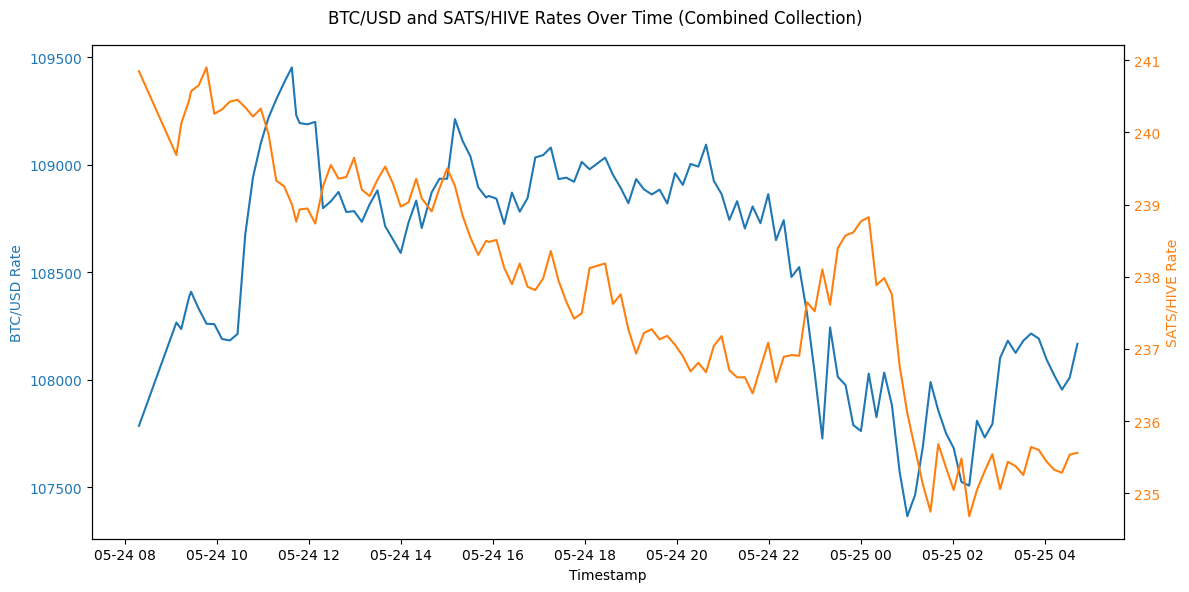

In [44]:
import pandas as pd
import matplotlib.pyplot as plt


collection = db["hive_rates_combined"]
# Query all documents from the combined collection
combined_cursor = collection.find({}, sort=[("timestamp", 1)])
combined_docs = await combined_cursor.to_list(length=None)

if combined_docs:
    df = pd.DataFrame(combined_docs)
    # Ensure timestamp is datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(df["timestamp"]):
        df["timestamp"] = pd.to_datetime(df["timestamp"])

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot BTC/USD on left y-axis
    ax1.plot(df["timestamp"], df["btc_usd"], label="BTC/USD Rate", color="tab:blue")
    ax1.set_xlabel("Timestamp")
    ax1.set_ylabel("BTC/USD Rate", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # Plot SATS/HIVE on right y-axis
    ax2 = ax1.twinx()
    ax2.plot(df["timestamp"], df["sats_hive"], label="SATS/HIVE Rate", color="tab:orange")
    ax2.set_ylabel("SATS/HIVE Rate", color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")

    fig.suptitle("BTC/USD and SATS/HIVE Rates Over Time (Combined Collection)")
    fig.tight_layout()
    plt.show()
else:
    print("No data found in hive_rates_combined collection.")
